In [1]:
from tqdm import tqdm

In [22]:
from transformers import PreTrainedTokenizerFast
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

In [84]:
import seaborn as sns

In [5]:
%matplotlib widget

In [6]:
ds = load_dataset("bigcode/stackv2_repo_context_sample")

Found cached dataset parquet (/transformers_cache/datasets/bigcode___parquet/bigcode--stackv2_repo_context_sample-e848b64a9740f86d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
sc_tokenizer = PreTrainedTokenizerFast(tokenizer_file="/data/tokenizers/tokenizer-the-stack-march-sample-v3-no-prefix-spaces/tokenizer.json")
gpt4_tokenizer = PreTrainedTokenizerFast(tokenizer_file="/data/tokenizers/gpt-4-tokenizer-sc-tokens/tokenizer.json")

In [8]:
def file_content(file):
    return f"<filename>{file['path']}\n{file['content']}"

def process_repo(repo):
    # Order files by path
    ordered_files = sorted(repo['files'], key=lambda f: f['path'])
    # print(f"File order:\n{[f['path'] for f in ordered_files]}")
    # Concatenate files
    repo_content = ''.join([file_content(f) for f in ordered_files])
    return repo_content

In [9]:
def tokenized_lengths(repo):
    content = process_repo(repo)
    tokenized = sc_tokenizer.encode(content)
    sc_length = len(tokenized)
    
    tokenized = gpt4_tokenizer.encode(content)
    gpt4_length = len(tokenized)
    return {
        "sc_length": sc_length,
        "gpt4_length": gpt4_length
    }
    

In [10]:
ds = ds['train'].map(tokenized_lengths, num_proc=4)

The OrderedVocab you are attempting to save contains a hole for index 100256, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100261, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100262, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100263, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100264, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100265, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100266, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100267, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100268, yo

Map (num_proc=4):   0%|          | 0/1002 [00:00<?, ? examples/s]

In [117]:
num_files = sum([len(repo['files']) for repo in ds])
print(f"Num files {num_files}")

Num files 24427


In [11]:
ds["sc_length"][:10]

[413647, 321229, 105808, 33869, 20432, 3175, 4665, 55881, 789, 3683]

In [18]:
ds["gpt4_length"][:10]

[355953, 314441, 99679, 27594, 15481, 2920, 4356, 47406, 657, 2984]

In [13]:
sc_lengths = ds["sc_length"]
gpt4_lengths = ds["gpt4_length"]

In [14]:
np.mean(sc_lengths), np.mean(gpt4_lengths)

(216255.0139720559, 170734.01996007984)

In [15]:
max(sc_lengths)

62858378

In [20]:
print(">8k", len([l for l in sc_lengths if l > 8192]))

>8k 413


In [16]:
#Num < 1e6
print("<10M", len([l for l in sc_lengths if l < 1e7]))
print("<1M", len([l for l in sc_lengths if l < 1e6]))
print("<100k", len([l for l in sc_lengths if l < 1e5]))
print("<10k", len([l for l in sc_lengths if l < 1e4]))
print("<1k", len([l for l in sc_lengths if l < 1e3]))
print("<100", len([l for l in sc_lengths if l < 1e2]))
print("<10", len([l for l in sc_lengths if l < 1e1]))

<10M 999
<1M 973
<100k 827
<10k 616
<1k 262
<100 108
<10 0


In [17]:
#Num < 1e6
print("<10M", len([l for l in gpt4_lengths if l < 1e7]))
print("<1M", len([l for l in gpt4_lengths if l < 1e6]))
print("<100k", len([l for l in gpt4_lengths if l < 1e5]))
print("<10k", len([l for l in gpt4_lengths if l < 1e4]))
print("<1k", len([l for l in gpt4_lengths if l < 1e3]))
print("<100", len([l for l in gpt4_lengths if l < 1e2]))
print("<10", len([l for l in gpt4_lengths if l < 1e1]))

<10M 1001
<1M 974
<100k 840
<10k 634
<1k 281
<100 114
<10 5


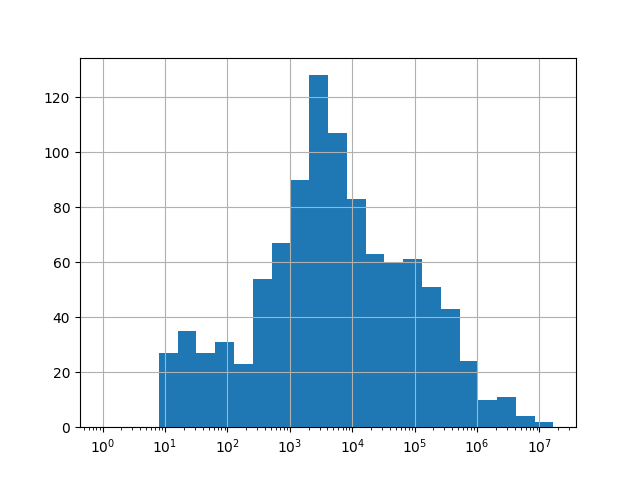

In [92]:
plt.figure()
plt.hist(sc_lengths, bins=[2**k for k in range(25)])
plt.xscale("log")
plt.grid()
plt.show()

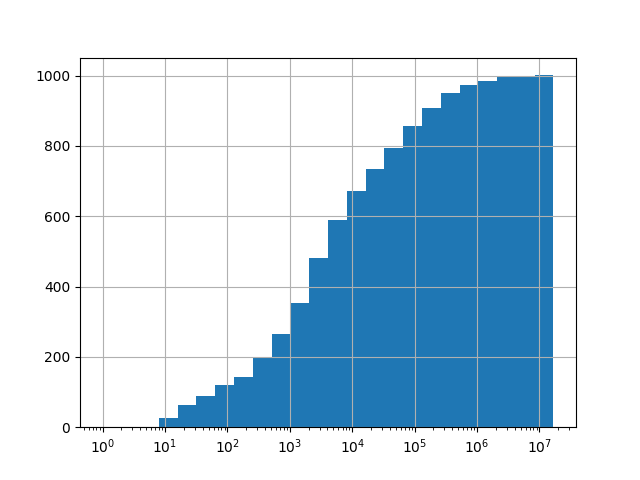

In [91]:
plt.figure()
plt.hist(sc_lengths, bins=[2**k for k in range(25)], cumulative=True)
plt.xscale("log")
plt.grid()
plt.show()

# Filtering

In [41]:
from pathlib import Path


In [29]:
import sys
sys.path.append("/home/toolkit/code/bigcode-dataset/preprocessing")

In [119]:
from filtering import load_filter_csv, language_format_from_dataset, LANG, filter_xml

In [66]:
from collections import Counter
not_csv_counter = Counter()

In [120]:
def filter_large_and_small_files(example):
    return 50 <= example['size'] and example['size'] <= 5000

def basic_filters_per_extension(example, ext_to_filter):
    """Filter files based on line length and % alphanumeric characters.
    The filtering parameters depend on the file extension, given by `ext_to_filter`"""
    # For .txt , whitelist requirements.txt
    if example[LANG] == "text" and example["ext"]:
        return example['path'].endswith("requirements.txt")
    # XML filter
    if example[LANG] != "xslt" and not filter_xml(example):
        return False
    # Large and small files
    if (example[LANG] == "json" or example[LANG] == "yaml") and not filter_large_and_small_files(example):
        return False
        
    # Get the filter-params we want to use
    # extension `None` is an empty string in the csv
    try:
        (include, line_max, line_mean, alphanum_frac, alphabetic_frac) = ext_to_filter[(language_format_from_dataset(
            example[LANG]), example["ext"] if example["ext"] is not None else ""
        )]
    except KeyError as e:
        # Some extensions are not in the csv. This happens for dockerfiles.
        # Exclude these files
        # logging.error(str(e) + f":{example['ext']} not in ext_to_filter")
        not_csv_counter.update([(language_format_from_dataset(example[LANG]), example["ext"])])
        include = False
    if not include:
        return False
    if line_max and example["max_line_length"] > line_max:
        return False
    elif line_mean and example["avg_line_length"] > line_mean:
        return False
    # Filter files with low percentage of alphanumeric chars
    elif alphanum_frac and example["alphanum_fraction"] < alphanum_frac:
        return False
    # Filter files with low percentage of alphabetic chars
    elif alphabetic_frac and sum(map(str.isalpha, example['content'])) < alphabetic_frac * len(example['content']):
        return False
    return True

In [72]:
per_extension_filter_csv = "/home/toolkit/code/bigcode-dataset/preprocessing/visual_inspection.csv"
ext_to_filter = load_filter_csv(per_extension_filter_csv)
# Add toml
ext_to_filter[("toml", "toml")] = ext_to_filter[("python", "py")]

def filter_repo(repo):
    for f in repo['files']:
        # Get some stats
        size = len(f["content"])
        line_lengths = [len(line) for line in f["content"].splitlines()]
        alpha_frac = np.mean([c.isalnum() for c in f["content"]])
        # Get the extension without the dot
        f['ext'] = Path(f['path']).suffix[1:]
        f['size'] = size
        f["avg_line_length"] = np.mean(line_lengths)
        f["max_line_length"] = max(line_lengths)
        f["alphanum_fraction"] = alpha_frac
    
    return {
        "files": [
            f for f in repo['files']
            if basic_filters_per_extension(f, ext_to_filter=ext_to_filter)
        ]
    }

In [73]:
filtered = ds.map(filter_repo, num_proc=4)

Map (num_proc=4):   0%|          | 0/1002 [00:00<?, ? examples/s]

In [80]:
filtered = filtered.map(tokenized_lengths, num_proc=4)

The OrderedVocab you are attempting to save contains a hole for index 100256, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100261, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100262, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100263, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100264, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100265, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100266, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100267, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100268, yo

Map (num_proc=4):   0%|          | 0/1002 [00:00<?, ? examples/s]

In [115]:
num_files = sum([len(repo['files']) for repo in filtered])
print(f"Num files {num_files}")

Num files 13831


In [114]:
filtered2 = ds.map(filter_repo, num_proc=4)

Map (num_proc=4):   0%|          | 0/1002 [00:00<?, ? examples/s]

In [116]:
num_files = sum([len(repo['files']) for repo in filtered2])
print(f"Num files {num_files}")

Num files 13823


In [121]:
filtered3 = ds.map(filter_repo, num_proc=4)

Map (num_proc=4):   0%|          | 0/1002 [00:00<?, ? examples/s]

In [123]:
filtered3 = filtered3.map(tokenized_lengths, num_proc=4)

The OrderedVocab you are attempting to save contains a hole for index 100256, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100261, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100262, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100263, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100264, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100265, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100266, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100267, your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains a hole for index 100268, yo

Map (num_proc=4):   0%|          | 0/1002 [00:00<?, ? examples/s]

In [122]:
num_files = sum([len(repo['files']) for repo in filtered3])
print(f"Num files {num_files}")

Num files 13823


In [77]:
len(filtered[11]['files'])

3

In [64]:
filtered_files = ds.map(filter_repo, num_proc=4)

Map (num_proc=4):   0%|          | 0/1002 [00:00<?, ? examples/s]

ERROR:root:('text', ''): not in ext_to_filter
ERROR:root:('yaml', 'lock'):lock not in ext_to_filter
ERROR:root:('ignore-list', ''): not in ext_to_filter
ERROR:root:('postscript', 'eps'):eps not in ext_to_filter
ERROR:root:('org', 'org'):org not in ext_to_filter
ERROR:root:('turtle', 'ttl'):ttl not in ext_to_filter
ERROR:root:('svg', 'svg'):svg not in ext_to_filter
ERROR:root:('gradle', 'gradle'):gradle not in ext_to_filter
ERROR:root:('xml', 'xml'):xml not in ext_to_filter
ERROR:root:('xml', 'xml'):xml not in ext_to_filter
ERROR:root:('xml', 'xml'):xml not in ext_to_filter
ERROR:root:('xml', 'xml'):xml not in ext_to_filter
ERROR:root:('xml', 'xml'):xml not in ext_to_filter
ERROR:root:('java-properties', 'properties'):properties not in ext_to_filter
ERROR:root:('xml', 'xml'):xml not in ext_to_filter
ERROR:root:('gradle', 'gradle'):gradle not in ext_to_filter
ERROR:root:('xml', 'xml'):xml not in ext_to_filter
ERROR:root:('xml', 'xml'):xml not in ext_to_filter
ERROR:root:('volt', 'volt'):

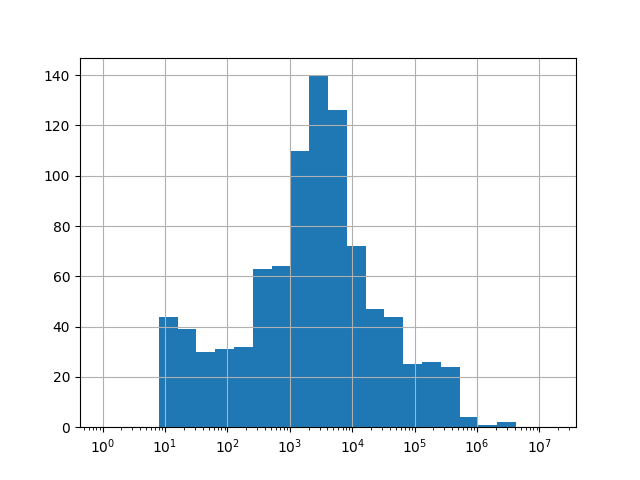

In [181]:
plt.figure()
plt.hist(filtered3["sc_length"], bins=[2**k for k in range(25)])
plt.xscale("log")
plt.grid()
plt.show()

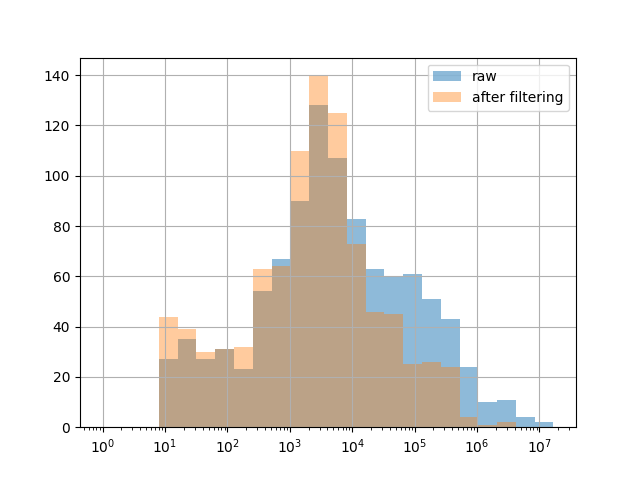

In [102]:
plt.figure()
plt.hist(sc_lengths, bins=[2**k for k in range(25)], alpha=0.5, label="raw")
plt.hist(filtered["sc_length"], bins=[2**k for k in range(25)], alpha=0.4, label="after filtering")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

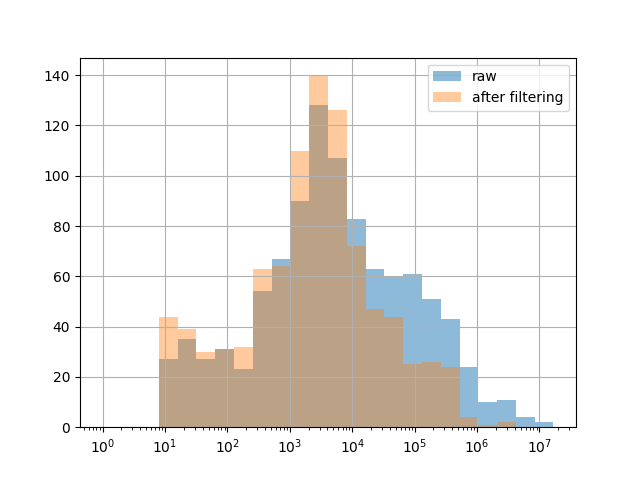

In [124]:
plt.figure()
plt.hist(sc_lengths, bins=[2**k for k in range(25)], alpha=0.5, label="raw")
plt.hist(filtered3["sc_length"], bins=[2**k for k in range(25)], alpha=0.4, label="after filtering")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

In [105]:
len(filtered)

1002

In [107]:
min(sc_lengths)

10

In [106]:
min(filtered["sc_length"])

0

In [125]:
print(">8k", len([l for l in filtered3["sc_length"] if l > 8192]))
print(">16k", len([l for l in filtered3["sc_length"] if l > 16000]))
#Num < 1e6
print("<10M", len([l for l in filtered3["sc_length"] if l < 1e7]))
print("<1M", len([l for l in filtered3["sc_length"] if l < 1e6]))
print("<100k", len([l for l in filtered3["sc_length"] if l < 1e5]))
print("<10k", len([l for l in filtered3["sc_length"] if l < 1e4]))
print("<1k", len([l for l in filtered3["sc_length"] if l < 1e3]))
print("<100", len([l for l in filtered3["sc_length"] if l < 1e2]))
print("<10", len([l for l in filtered3["sc_length"] if l < 1e1]))

>8k 245
>16k 173
<10M 1002
<1M 999
<100k 935
<10k 777
<1k 378
<100 207
<10 79


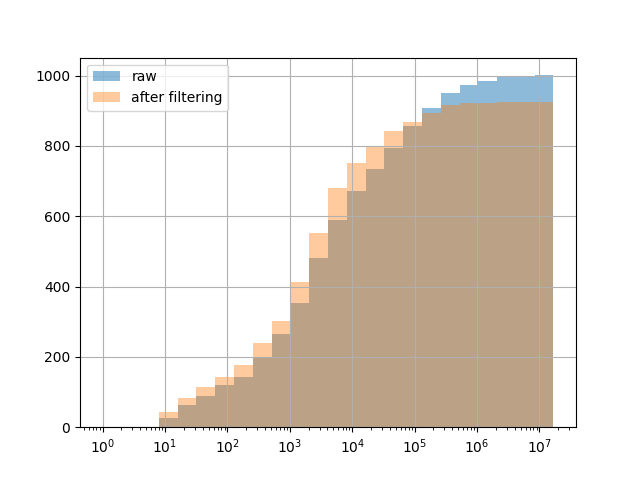

In [126]:
plt.figure()

plt.hist(sc_lengths, bins=[2**k for k in range(25)], cumulative=True, alpha=0.5, label="raw")
plt.hist(filtered3["sc_length"], bins=[2**k for k in range(25)], cumulative=True, alpha=0.4, label="after filtering")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

### By number of tokens instead of repos

In [175]:
# Cumulative distribution of the document-length on the token level.
repo_length_lims = [2**k for k in range(26)]
total_tokens = sum(filtered3["sc_length"])
# Number of tokens in documents (repos) of length lower than the given limit.
y = [sum([l for l in filtered3["sc_length"] if l < x]) for x in repo_length_lims]
y_normalized = [e / total_tokens for e in y]

num_repos_below_limit = [len([l for l in filtered3["sc_length"] if l < x]) for x in repo_length_lims]

In [184]:
sum([l for l in filtered3["sc_length"] if l < 8192]) / total_tokens

0.04646120064680181

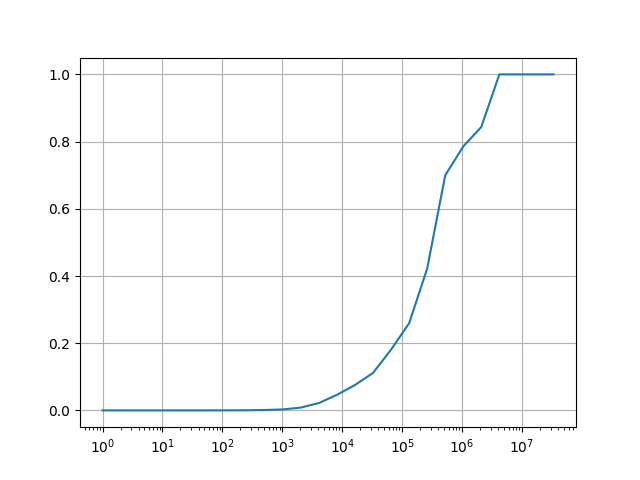

In [180]:
plt.figure()
plt.plot(repo_length_lims, y_normalized)
plt.grid()
plt.xscale("log")
# plt.title("Cumulative distribution of sequence-lengths")
plt.show()

In [ ]:
[e for e in filtered3]

# Python repos

In [137]:
def repo_language(repo):
    file_languages = [f[LANG] for f in repo['files']]
    if len(file_languages) > 0:
        return {"repo_language": Counter(file_languages).most_common(1)[0][0]}
    else:
        return {"repo_language": None}

In [138]:
repo_language(filtered3[0])

{'repo_language': 'Rust'}

In [139]:
filtered3 = filtered3.map(repo_language, num_proc=4)

Map (num_proc=4):   0%|          | 0/1002 [00:00<?, ? examples/s]

In [142]:
python_subset = filtered3.filter(lambda r: r["repo_language"] == "Python")

Filter:   0%|          | 0/1002 [00:00<?, ? examples/s]

In [152]:
len(python_subset)

83

In [153]:
max(python_subset["sc_length"])

185339

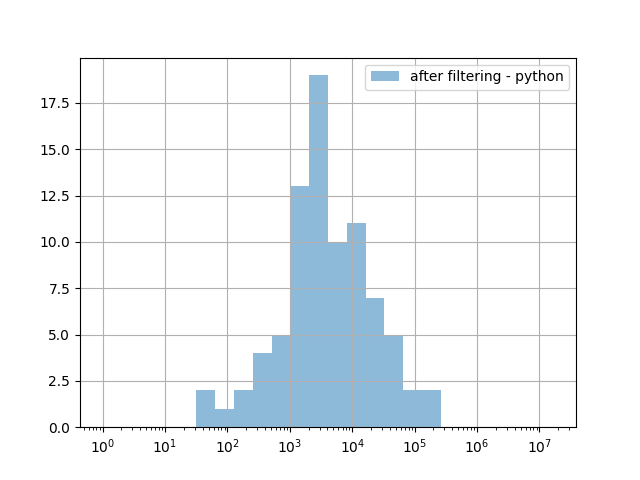

In [156]:
plt.figure()
# plt.hist(filtered3["sc_length"], bins=[2**k for k in range(25)], alpha=0.5, label="after filtering")
plt.hist(python_subset["sc_length"], bins=[2**k for k in range(25)], alpha=0.5, label="after filtering - python")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

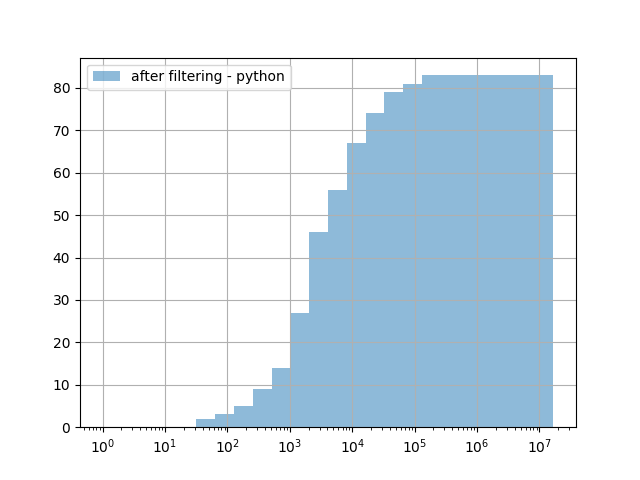

In [157]:
plt.figure()
# plt.hist(filtered3["sc_length"], bins=[2**k for k in range(25)], alpha=0.5, label="after filtering")
plt.hist(python_subset["sc_length"], bins=[2**k for k in range(25)], alpha=0.5, cumulative=True, label="after filtering - python")
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

In [140]:
filtered3[0]

{'repo_name': 'rehack/swc',
 'repo_url': 'https://github.com/rehack/swc',
 'snapshot_id': 'a076ed7cc66678c23d5df2c722f504dd975a1b80',
 'revision_id': 'd19df1379cc24fd14089c815badbca2be533fa48',
 'branch_name': 'refs/heads/master',
 'visit_date': Timestamp('2023-08-11 03:05:08.228166'),
 'revision_date': Timestamp('2021-10-08 15:05:59'),
 'committer_date': Timestamp('2021-10-08 15:05:59'),
 'github_id': None,
 'star_events_count': 0,
 'fork_events_count': 0,
 'gha_license_id': None,
 'gha_fork': None,
 'gha_event_created_at': None,
 'gha_created_at': None,
 'gha_updated_at': None,
 'gha_pushed_at': None,
 'gha_size': None,
 'gha_stargazers_count': None,
 'gha_forks_count': None,
 'gha_open_issues_count': None,
 'gha_language': None,
 'gha_archived': None,
 'gha_disabled': None,
 'files': [{'alphanum_fraction': 0.5116555443824847,
   'avg_line_length': 22.029473684210526,
   'blob_id': 'f0af42828749d26140e01b3b7f9be8d8cf2a5988',
   'content': 'use rustc_hash::FxHashSet;\nuse std::time::I

In [81]:
len(ds[11]['files'])

4

In [60]:
files = filter_repo(ds[0])

ERROR:root:('toml', 'lock'):lock not in ext_to_filter


In [61]:
len(files['files'])

100

In [ ]:
language = "python"

per_extension_filter_csv = "/home/toolkit/code/bigcode-dataset/preprocessing/visual_inspection.csv"
ext_to_filter = load_filter_csv(args.per_extension_filter_csv)

filtered = ds.filter(partial(basic_filters_per_extension, ext_to_filter=ext_to_filter))
